In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

<br>

# Residual Networks
---



<br>

### The principle

* help training by skipping layer at the very beginning
* if skip more than 1, use a layer
* use NetworkX to show the diagram

<br>

### Example: simple function

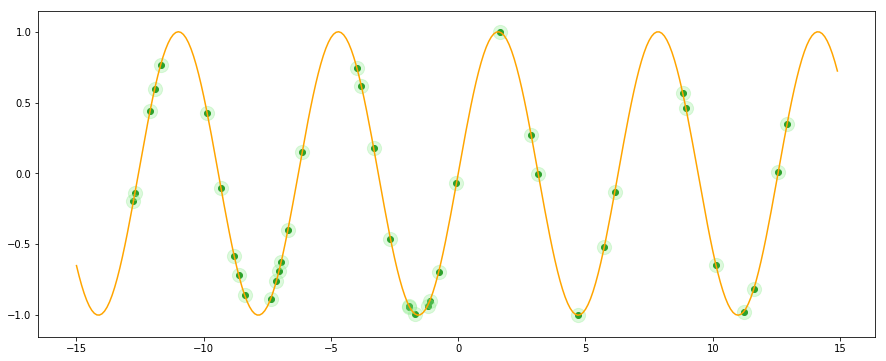

In [21]:
train_xs = np.random.uniform(-13, 13, size=40)
train_ys = np.sin(train_xs)

test_xs = np.arange(-15, 15, 0.1)
test_ys = np.sin(test_xs)

plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys, color='green')
plt.scatter(train_xs, train_ys, s=200, color="lightgreen", alpha=0.3)
plt.plot(test_xs, test_ys, color='orange')
plt.show()

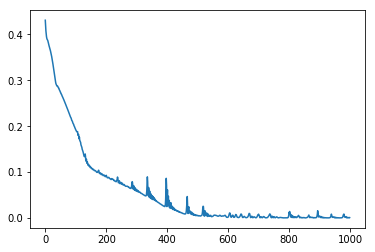

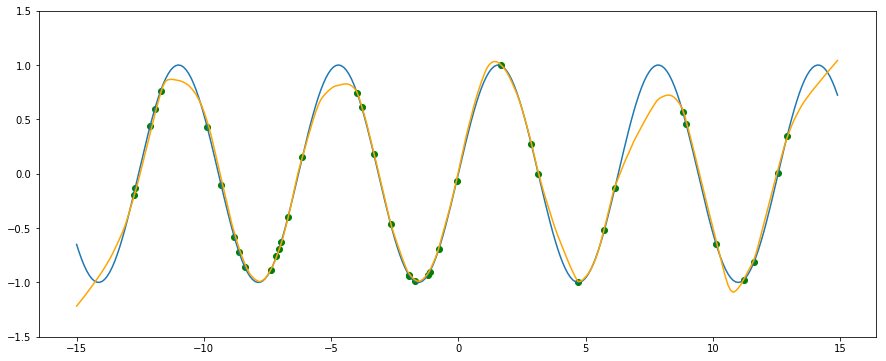

In [27]:
class VanillaFullyConnectedNN(nn.Module):
    def __init__(self, hidden_levels: int, hidden_size: int):
        super().__init__()
        levels = []
        for _ in range(hidden_levels):
            levels.append(nn.Linear(hidden_size, hidden_size))
            levels.append(nn.ReLU())
        self.fc = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            *levels,
            nn.Linear(hidden_size, 1))
    
    def forward(self, xs):
        return self.fc(xs)

    
def train(model, train_xs, train_ys, epoch_nb: int):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    ds = data.TensorDataset(torch.FloatTensor(train_xs).unsqueeze(-1),
                            torch.FloatTensor(train_ys).unsqueeze(-1))
    loader = data.DataLoader(ds, batch_size=100, shuffle=True)

    losses = []
    for _ in range(epoch_nb):
        episode_loss = 0.
        for x, y in loader:
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()
        losses.append(episode_loss)
    return losses


def predict(model, test_xs):
    model.eval()
    return model(torch.FloatTensor(test_xs).unsqueeze(-1)).detach().numpy()


model = VanillaFullyConnectedNN(hidden_levels=5, hidden_size=256)
losses = train(model, train_xs, train_ys, epoch_nb=1000)
ys_pred = predict(model, test_xs)
plt.plot(losses)
plt.show()

plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys, color='green')
plt.plot(test_xs, test_ys)
plt.plot(test_xs, ys_pred, color='orange')
plt.ylim(-1.5, 1.5)
plt.show()

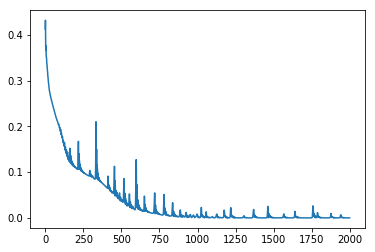

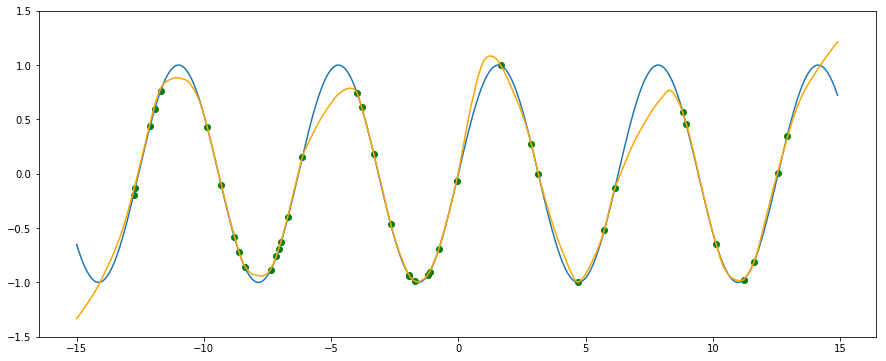

In [43]:
class ResidualNet(nn.Module):
    def __init__(self, hidden_levels: int, hidden_size: int):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.layers = []
        previous_size = 1
        for i in range(hidden_levels):
            self.layers.append(nn.Linear(hidden_size + previous_size, hidden_size))
            self.add_module('hidden ' + str(i), self.layers[-1])
            previous_size = hidden_size
        self.fcN = nn.Linear(hidden_size + previous_size, 1)
        self.relu = nn.ReLU()
    
    def forward(self, xs):
        ys = self.relu(self.fc1(xs))
        for l in self.layers:
            # TODO - JOIN before or after the RELU?
            xs, ys = ys, self.relu(l(torch.cat((xs, ys), dim=-1)))
        return self.fcN(torch.cat((xs, ys), dim=-1))


model = ResidualNet(hidden_levels=5, hidden_size=256)
losses = train(model, train_xs, train_ys, epoch_nb=2000)
ys_pred = predict(model, test_xs)
plt.plot(losses)
plt.show()


plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys, color='green')
plt.plot(test_xs, test_ys)
plt.plot(test_xs, ys_pred, color='orange')
plt.ylim(-1.5, 1.5)
plt.show()